# BPML - Submission 2
Dataset yang digunakan merupakan data histori harga saham AMAZON dari tahun 2006 hingga tahun 2017. Pada project ini data yang digunakan merupakan harga saham tertinggi pada hari itu.

### Mengimport dataset menggunakan pandas
Dataset diimport kemudian ditampilkan 5 data terakhir

In [1]:
import pandas as pd
df = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


### Menampilkan deskripsi data

In [2]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


### Membagi data test dan dat train
Data test yang digunakan dari tahun 2006 hingga tahun 2015 (10 tahun). Sedangkan data test yang digunakan dari tahun 2016 hingga tahun 2018 (3 tahun)

In [5]:
high = df['High']
high_train = df['High']['2006':'2014']
high_test = df['High']['2015':'2017']

In [6]:
high.describe()

count    3019.000000
mean      302.371163
std       281.826442
min        26.300000
25%        82.580000
50%       208.000000
75%       379.155000
max      1213.410000
Name: High, dtype: float64

In [ ]:
high_train.size , high_test.size

### Menampilkan plot perubahan data

In [5]:
import matplotlib.pyplot as plt
high_train.plot(subplots=True, figsize=(10,4))
plt.show()

<Figure size 1000x400 with 1 Axes>

### Buat fungsi untuk melakukan windowing

In [6]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

### Melakukan windowing

In [7]:
train_set = windowed_dataset(high_train, window_size=250, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(high_test, window_size=250, batch_size=100, shuffle_buffer=1000)

### Arsitektur model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

ts_model = Sequential()
ts_model.add(LSTM(100, return_sequences=True))
ts_model.add(LSTM(200))
ts_model.add(Dense(100, activation='relu'))
ts_model.add(Dense(50, activation='relu'))
ts_model.add(Dense(10, activation='relu'))
ts_model.add(Dense(1))

### Mengompile model

In [9]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

optimizer = SGD(lr=0.9200e-01, momentum=0.9)
ts_model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])

### Melakukan fitting pada model

In [10]:
epochs_num = 100
ts_history = ts_model.fit(train_set, epochs=epochs_num)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
21/21 [==============================] - 7s 344ms/step - loss: 171.0756 - mae: 172.3298
Epoch 2/100
21/21 [==============================] - 4s 187ms/step - loss: 141.1651 - mae: 141.9944
Epoch 3/100
21/21 [==============================] - 4s 187ms/step - loss: 123.1022 - mae: 123.7816
Epoch 4/100
21/21 [==============================] - 4s 184ms/step - loss: 109.0881 - mae: 109.7006
Epoch 5/100
21/21 [==============================] - 4s 185ms/step - loss: 98.6273 - mae: 99.2811
Epoch 6/10

### Grafik perubahan mae terhadap jumlah epoch

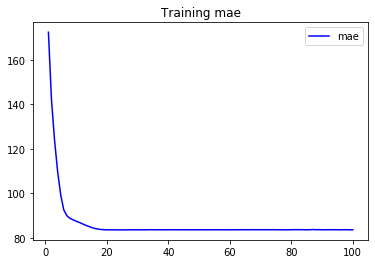

In [11]:
import matplotlib.pyplot as plt

mae = ts_history.history['mae']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'blue', label='mae')
plt.title('Training mae')
plt.legend()
plt.show()